In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.integrate import odeint, solve_ivp
from scipy.special import lpmn
from scipy.io import savemat, loadmat
import pandas as pd
from datetime import datetime
import sympy as sym
import csv
from filterpy.kalman import ExtendedKalmanFilter
from fp_utils import *

In [2]:

obs_mat_3d = loadmat('LEO_DATA_Apparent_3Days.mat')
obs_mat_4_6 = loadmat('LEO_DATA_Apparent_Days4-6.mat')
obs_mat_4_6['LEO_DATA_Apparent'][:,1] += 3*86400
obs_mat = np.concatenate((obs_mat_3d['LEO_DATA_Apparent'], obs_mat_4_6['LEO_DATA_Apparent']), axis=0)

#switch for observations
obs_time = obs_mat[:, 1]

# obs_id = obs_mat[:, 0]
np.set_printoptions(suppress=True)



In [3]:
#constants
mu = 398600.4415 #m^3/s^2
# R_earth = 6378.137 #km

e_earth = 0.0818191908426215
omega_earth = 7.2921158553E-5 #rad/s
AU = 149597870.6 #km

#initial state
# r_ECI = np.array([6984.45711518852, 1612.2547582643, 13.0925904314402])*1000 #m

# v_ECI = np.array([-1.67667852227336, 7.26143715396544, 0.259889857225218])*1000 #m/s

r_ECI = np.array([6978.883860074742, 1615.7622342575391, 19.48509793007517])
v_ECI = np.array([-1.6622408967796873, 7.26097148769649, 0.2705834331704228])



#station locations
stations = np.array([[-6143.584, 1364.250, 1033.743], 
                    [1907.295, 6030.810, -817.119],
                    [2390.310, -5564.341, 1994.578]]) #m

#time
JD_UTC = gregorian_to_jd(2018, 3, 23, 8, 55, 3)
leap_sec = 37 #s
x_p = np.array([20.816, 22.156, 23.439, 24.368, 25.676, 26.952, 28.108])/1000 #arcsec
y_p = np.array([381.008, 382.613, 384.264, 385.509, 386.420, 387.394, 388.997])/1000 #arcsec
del_UT1 = np.array([144.0585, 143.1048, 142.2335, 141.3570, 140.4078, 139.3324, 138.1510])/1000 #s
LOD = np.array([1.0293,0.9174, 0.8401, 0.8810, 1.0141, 1.1555, 1.2568])/1000 #s
C, S = load_egm96_coefficients()

print(obs_mat[obs_mat[:, 0] == 1, 3][0])


-5.672236822630331


In [4]:
np.set_printoptions(precision=16, suppress=False)
seconds = 10000

obs_id = np.array(obs_mat[:, 0], dtype=int)

case = 'F'

y_arr, P_hat, P_bar, P_ZZ, obs_mat_EKF, Q, post_fit_res, pre_fit_res, phi = EKF(case, r_ECI, v_ECI, stations, JD_UTC, seconds)



Case:  F
Running...
Day:  0
pre_fit_res [2.9355902677252743e-03 2.9998859262470035e-05]
pre_fit_res [-2.9875647348944767e-03  3.9356571100324089e-05]
pre_fit_res [-1.7839366851148952e-03 -2.8734700130428337e-06]
pre_fit_res [ 5.414076017586922e-03 -2.595448135994660e-07]
pre_fit_res [1.3820399021824414e-03 3.5586630009465381e-06]


KeyboardInterrupt: 

In [4]:
#postfit RMS
# df_calc = pd.read_csv('range_rate_case' + case + '.csv', names=column_names)
#Comparing Pre-fit residuals
t = obs_mat_EKF[:, 1]
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
residuals = post_fit_res

if case == 'A' or case == 'B' or case == 'C' or case == 'F' or case == 'G':


    r_residuals_kwaj = residuals[np.where(obs_mat_EKF[:, 0] == 1)[0], 0]/1000
    rr_residuals_kwaj = residuals[np.where(obs_mat_EKF[:, 0] == 1)[0], 1]/1000

    RMS_Kwaj_r = np.sqrt(np.mean((r_residuals_kwaj)**2))
    RMS_Kwaj_rr = np.sqrt(np.mean((rr_residuals_kwaj)**2))

    t_kwaj = obs_mat_EKF[np.where(obs_mat_EKF[:, 0] == 1)[0], 1]

    print("Kwaj Range RMS:", RMS_Kwaj_r, "[km]")
    print("Kwaj Range Rate RMS:", RMS_Kwaj_rr,"[km/s]")

    ax[0].scatter(t_kwaj, r_residuals_kwaj, label='Kwaj Range Residuals')
    ax[1].scatter(t_kwaj, rr_residuals_kwaj, label='Kwaj Range Rate Residuals')

if case == 'A' or case == 'B' or case == 'D' or case == 'F' or case == 'G':


    r_residuals_dg = residuals[np.where(obs_mat_EKF[:, 0] == 2)[0], 0]/1000
    rr_residuals_dg = residuals[np.where(obs_mat_EKF[:, 0] == 2)[0], 1]/1000

    RMS_Diego_r = np.sqrt(np.mean((r_residuals_dg)**2))
    RMS_Diego_rr = np.sqrt(np.mean((rr_residuals_dg)**2))

    t_diego = obs_mat_EKF[np.where(obs_mat_EKF[:, 0] == 2)[0], 1]

    print("Diego Range RMS:", RMS_Diego_r, "[km]")
    print("Diego Range Rate RMS:", RMS_Diego_rr,"[km/s]")

    ax[0].scatter(t_diego, r_residuals_dg, label='Diego Range Residuals')
    ax[1].scatter(t_diego, rr_residuals_dg, label='Diego Range Rate Residuals')


if case == 'A' or case == 'B' or case == 'E' or case == 'F' or case == 'G':


    r_residuals_arecibo = residuals[np.where(obs_mat_EKF[:, 0] == 3)[0], 0]/1000
    rr_residuals_arecibo = residuals[np.where(obs_mat_EKF[:, 0] == 3)[0], 1]/1000

    RMS_Arecibo_r = np.sqrt(np.mean((r_residuals_arecibo)**2))
    RMS_Arecibo_rr = np.sqrt(np.mean((rr_residuals_arecibo)**2))

    t_arecibo = obs_mat_EKF[np.where(obs_mat_EKF[:, 0] == 3)[0], 1]

    print("Arecibo Range RMS:", RMS_Arecibo_r, "[km]")
    print("Arecibo Range Rate RMS:", RMS_Arecibo_rr,"[km/s]")

    ax[0].scatter(t_arecibo, r_residuals_arecibo, label='Arecibo Range Residuals')
    ax[1].scatter(t_arecibo, rr_residuals_arecibo, label='Arecibo Range Rate Residuals')


three_sigma_pos = np.array([np.sqrt(P_ZZ[i][0]/1000**2)*3 for i in range(len(t))])
three_sigma_vel = np.array([np.sqrt(P_ZZ[i][3]/1000**2)*3 for i in range(len(t))])

# print(three_sigma_pos)
ax[0].plot(t, three_sigma_pos, label='+3$\sigma$')
ax[0].plot(t, -three_sigma_pos, label='-3$\sigma$')
ax[1].plot(t, three_sigma_vel, label='+3$\sigma$')
ax[1].plot(t, -three_sigma_vel, label='-3$\sigma$')



ax[0].set_title('Range Residuals')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Range Residuals [km]')
ax[0].set_ylim(-0.1, 0.1)
ax[0].legend()


ax[1].set_title('Range Rate Residuals')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Range Rate Residuals [km/s]')
ax[1].set_ylim(-0.00005, 0.00005)
ax[1].legend()
plt.show()
# fig.savefig('residuals_case' + case+ '.png', dpi=300)


NameError: name 'obs_mat_EKF' is not defined

In [5]:
seconds = 20000
cases = ['F']

for case in cases:
    # with open('Results/Case' + case + '/range_rate_RMS_case'  + case + '_P.csv', 'w') as csvfile:
    #                 writer = csv.writer(csvfile, delimiter=',',
    #                                         quotechar='|', quoting=csv.QUOTE_MINIMAL)
    #                 writer.writerow(['KR', 'KRR', 'DR', 'DRR', 'AR', 'ARR', 'Psx', 'Psy', 'Psz', 'x', 'y', 'z', 'vx', 'vy', 'vz'])
    P_sigma_x = np.arange(5, 6, 1)
    P_sigma_y = np.arange(5, 6, 1)
    P_sigma_z = np.arange(5, 6, 1)
    for Px in P_sigma_x:
        for Py in  P_sigma_y:
            for Pz in P_sigma_z:
                print(Px, Py, Pz)
                y_arr, P_hat, P_bar, P_ZZ, obs_df, Q, rho, rho_dot, phi = EKF(case, r_ECI, v_ECI, obs_df, stations, JD_UTC, seconds, 10.0**Px, 10.0**Py, 10.0**Pz)


                #write EKF results to csv
                obs_time = obs_df['time'].values
                obs_id = obs_df['id'].values
                m = obs_df['time'].index[obs_time < seconds].values[-1]
                # print(m)
                t = obs_df['time'][0:m].values

                with open('range_rate_case' + case + '.csv', 'w') as csvfile:
                    writer = csv.writer(csvfile, delimiter=',',
                                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
                    for i in range(0, len(t)):
                        station_index = obs_id[i]-1
                        writer.writerow([station_index+1, obs_time[i], rho[i]/1000, rho_dot[i]/1000])

                

                #postfit RMS
                df_calc = pd.read_csv('range_rate_case' + case + '.csv', names=column_names)
                #Comparing Pre-fit residuals
                fig, ax = plt.subplots(2, 1, figsize=(10, 10))

                if case == 'A' or case == 'B' or case == 'C' or case == 'F' or case == 'G':
                    r_calc_Kwaj = df_calc['range'][df_calc.index[df_calc['id']==1]]
                    rr_calc_Kwaj = df_calc['range_rate'][df_calc.index[df_calc['id']==1]]

                    r_obs_Kwaj = obs_df.iloc[:m]['range'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==1]]
                    rr_obs_Kwaj = obs_df.iloc[:m]['range_rate'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==1]]

                    RMS_Kwaj_r = np.sqrt(np.mean((r_obs_Kwaj - r_calc_Kwaj)**2))
                    RMS_Kwaj_rr = np.sqrt(np.mean((rr_obs_Kwaj - rr_calc_Kwaj)**2))

                    t_kwaj = obs_df.iloc[:m]['time'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==1]]

                    print("Kwaj Range RMS:", RMS_Kwaj_r, "[km]")
                    print("Kwaj Range Rate RMS:", RMS_Kwaj_rr,"[km/s]")

                    ax[0].scatter(t_kwaj, r_obs_Kwaj - r_calc_Kwaj, label='Kwaj Range Residuals')
                    ax[1].scatter(t_kwaj, rr_obs_Kwaj - rr_calc_Kwaj, label='Kwaj Range Rate Residuals')

                if case == 'A' or case == 'B' or case == 'D' or case == 'F' or case == 'G':

                    r_calc_Diego = df_calc['range'][df_calc.index[df_calc['id']==2]]
                    rr_calc_Diego = df_calc['range_rate'][df_calc.index[df_calc['id']==2]]

                    r_obs_Diego = obs_df.iloc[:m]['range'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==2]]
                    rr_obs_Diego = obs_df.iloc[:m]['range_rate'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==2]]

                    RMS_Diego_r = np.sqrt(np.mean((r_obs_Diego - r_calc_Diego)**2))
                    RMS_Diego_rr = np.sqrt(np.mean((rr_obs_Diego - rr_calc_Diego)**2))

                    t_diego = obs_df.iloc[:m]['time'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==2]]

                    print("Diego Range RMS:", RMS_Diego_r, "[km]")
                    print("Diego Range Rate RMS:", RMS_Diego_rr,"[km/s]")

                    ax[0].scatter(t_diego, r_obs_Diego - r_calc_Diego, label='Diego Range Residuals')
                    ax[1].scatter(t_diego, rr_obs_Diego - rr_calc_Diego, label='Diego Range Rate Residuals')


                if case == 'A' or case == 'B' or case == 'E' or case == 'F' or case == 'G':

                    r_calc_Arecibo = df_calc['range'][df_calc.index[df_calc['id']==3]]
                    rr_calc_Arecibo = df_calc['range_rate'][df_calc.index[df_calc['id']==3]]


                    r_obs_Arecibo = obs_df.iloc[:m]['range'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==3]]
                    rr_obs_Arecibo = obs_df.iloc[:m]['range_rate'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==3]]

                    RMS_Arecibo_r = np.sqrt(np.mean((r_obs_Arecibo - r_calc_Arecibo)**2))
                    RMS_Arecibo_rr = np.sqrt(np.mean((rr_obs_Arecibo - rr_calc_Arecibo)**2))

                    t_arecibo = obs_df.iloc[:m]['time'][obs_df.iloc[:m].index[obs_df.iloc[:m]['id']==3]]

                    print("Arecibo Range RMS:", RMS_Arecibo_r, "[km]")
                    print("Arecibo Range Rate RMS:", RMS_Arecibo_rr,"[km/s]")

                    ax[0].scatter(t_arecibo, r_obs_Arecibo - r_calc_Arecibo, label='Arecibo Range Residuals')
                    ax[1].scatter(t_arecibo, rr_obs_Arecibo - rr_calc_Arecibo, label='Arecibo Range Rate Residuals')


                three_sigma_pos = np.array([np.sqrt(P_ZZ[i][0]/1000**2)*3 for i in range(len(t))])
                three_sigma_vel = np.array([np.sqrt(P_ZZ[i][3]/1000**2)*3 for i in range(len(t))])

                # print(three_sigma_pos)
                ax[0].plot(t, three_sigma_pos, label='+3$\sigma$')
                ax[0].plot(t, -three_sigma_pos, label='-3$\sigma$')
                ax[1].plot(t, three_sigma_vel, label='+3$\sigma$')
                ax[1].plot(t, -three_sigma_vel, label='-3$\sigma$')



                ax[0].set_title('Range Residuals')
                ax[0].set_xlabel('Time [s]')
                ax[0].set_ylabel('Range Residuals [km]')
                ax[0].set_ylim(-0.05, 0.05)
                ax[0].legend()


                ax[1].set_title('Range Rate Residuals')
                ax[1].set_xlabel('Time [s]')
                ax[1].set_ylabel('Range Rate Residuals [km/s]')
                ax[1].set_ylim(-0.0005, 0.0005)
                ax[1].legend()
                fig.savefig('Results/Case' + case + '/Plots/residuals_case' + case + '_P_' + str(Px) + '_' + str(Py) + '_' + str(Pz) + '.png', dpi=300)
                plt.close()
                F = A_Matrix()
                del_t = seconds-t[-1]
                phi = np.eye(6)
                t_eval = np.arange(t[-1], 86460, 60)
                y0 = np.concatenate((y_arr[-1][0:6], phi.ravel()))
                sol_final = solve_ivp(satellite_motion_phi, [t[-1], 86400], y0, t_eval=t_eval, args=(F, JD_UTC), rtol=3E-14, atol=1E-16)
                y_final = sol_final.y[0:6, -1]
                with open('Results/Case' + case + '/range_rate_RMS_case'  + case + '_P.csv', 'a') as csvfile:
                    writer = csv.writer(csvfile, delimiter=',',
                                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
                    writer.writerow([RMS_Kwaj_r, RMS_Kwaj_rr, RMS_Diego_r, RMS_Diego_rr, RMS_Arecibo_r, RMS_Arecibo_rr, Px, Py, Pz, y_final[0], y_final[1], y_final[2], y_final[3], y_final[4], y_final[5]])


            



5 5 5
Case:  F
pre_fit_res [-0.66531943  0.00091341]
Running EKF...
Day:  0
pre_fit_res [ 0.00166523 -0.00000379]
post_fit_res [-0.00158723 -0.000007  ]
pre_fit_res [-0.00534763  0.00007335]
post_fit_res [-0.00484948 -0.00001428]
pre_fit_res [-0.00594854 -0.00005072]
post_fit_res [-0.00275599 -0.00000482]
pre_fit_res [ 0.00366221 -0.0000042 ]
post_fit_res [0.00293633 0.00000029]
pre_fit_res [0.0003275  0.00001662]
post_fit_res [-0.00191973  0.00000558]
pre_fit_res [-0.00464201  0.00000744]
post_fit_res [-0.00732239  0.00000158]
pre_fit_res [-0.00177506  0.0000011 ]
post_fit_res [-0.00177755  0.00000012]
pre_fit_res [-0.01221918  0.00000035]
post_fit_res [-0.01122556  0.00000005]
pre_fit_res [-0.00739972  0.00000167]
post_fit_res [-0.00669498  0.00000035]
pre_fit_res [-0.00771596  0.00000193]
post_fit_res [-0.00693999  0.00000047]
station:  1
pre_fit_res [-0.33900998 -0.00601319]
post_fit_res [-0.00795694 -0.00004145]
pre_fit_res [ 0.00121497 -0.00003771]
post_fit_res [-0.05621826 -0.00

In [4]:
def a_drag_sol_2(C_D, r, v, s):

    '''
    Computes the acceleration due to atmospheric drag

    Inputs:
    C_D - drag coefficient
    r - position vector in ECI frame [m]
    v - velocity vector in ECI frame [m/s]
    r_sun - position vector of sun in ECI frame [m]

    Outputs:
    a_drag - acceleration due to atmospheric drag [m/s^2]
    
    '''
    # Calculate the magnitude of the position vector
    r_mag = np.linalg.norm(r)

    # Define drag parameters
    R_earth = 6378.1363 #[m]
    m = 2000 #[kg]
    theta_dot = 7.292115146706979E-5 #[rad/s]
    C_D = 0.3 # Drag coefficient

    # Calculate velocity in atmosphere
    V_A_bar = np.array([v[0]+theta_dot*r[1], v[1]-theta_dot*r[0], v[2]])

    # Create unit vectors in body frame
    n_hat = np.eye(3)
    T_hat = V_A_bar/np.linalg.norm(V_A_bar)
    W_hat = np.cross(r, V_A_bar)/np.linalg.norm(np.cross(r, V_A_bar))
    N_hat = np.cross(T_hat, W_hat)

    # Transform from body frame to ECI frame
    Qbf2eci = np.array([T_hat, W_hat, N_hat]).T

    Qbf2eci = orthodcm(Qbf2eci)

    # Calculate components of n_hat in ECI frame
    n_hat_eci_x = (Qbf2eci @ n_hat[0])
    n_hat_eci_y = (Qbf2eci @ n_hat[1])
    n_hat_eci_z = (Qbf2eci @ n_hat[2])

    # Calculate cross sectional area for each component
    A_Cross_x = (n_hat_eci_x @ T_hat)*(6E-6)
    A_Cross_y = (n_hat_eci_y @ T_hat)*(8E-6)
    A_Cross_z = (n_hat_eci_z @ T_hat)*(12E-6)

    

    # Define atmospheric parameters
    rho_0 = 3.614E-4 #[kg/km^3]
    H = 88667.0/1E3 #[km]
    r0 = (700.0 + R_earth) #[m]

    # # Check if satellite is in shadow of earth
    tau_min = (np.linalg.norm(r)**2 - np.dot(r, s))/(np.linalg.norm(r)**2 + np.linalg.norm(s)**2 - 2*np.dot(r, s))
    if tau_min < 0:
        # Compute vector between sun and satellite
        r_sat_sun = (s-r)/np.linalg.norm(s-r)

        # Calculate solar panel contribution to drag
        # n_hat_sol = (Qbf2eci @ r_sat_sun)

        n_hat_bf_sol = np.cross(n_hat, r_sat_sun)
        n_hat_eci_sol = (Qbf2eci @ n_hat_bf_sol)
        print('n_hat_sol: ', n_hat_bf_sol)

        A_Cross_x += abs((n_hat_eci_sol[0] @ T_hat))*(15E-6)
        A_Cross_y += abs((n_hat_eci_sol[1] @ T_hat))*(15E-6)
        A_Cross_z += abs((n_hat_eci_sol[2] @ T_hat))*(15E-6)


        
    # Calculate total cross sectional area
    A_Cross = np.array([A_Cross_x, A_Cross_y, A_Cross_z])

    print('A_Cross: ', A_Cross*1000**2)
    # Calculate atmospheric density
    rho_A = rho_0*np.exp(-(r_mag-r0)/H)

    # Calculate velocity in atmosphere
    V_A = np.sqrt((v[0] + theta_dot*r[1])**2 +(v[1]-theta_dot*r[0])**2 + v[2]**2)

    # Return drag force
    return -1/2*C_D*rho_A*V_A*np.multiply(A_Cross, V_A_bar)/m
# r_test = np.array([6984.46459301679,1612.22237259524,13.0914313353482]) #m
# v_test = np.array([-1.67664476668291,7.26144494619245,0.259889921085112]) #m/s
r_test = r_ECI
v_test = v_ECI
# JD = gregorian_to_jd(2018, 3, 23, 5, 0, 0)
x_p, y_p, del_UT1, JD_UTC = interp_EOP(JD_UTC)
r_sun = sun_position_vector(JD_UTC, del_UT1, 37)
drag = a_drag_sol_2(1.88, r_ECI, v_ECI, r_sun)
print(drag)



n_hat_sol:  [[ 0.          0.17525148 -0.36906674]
 [-0.17525148  0.         -0.91273033]
 [ 0.36906674  0.91273033 -0.        ]]
A_Cross:  [17.27614478  4.97915683  0.17436856]
[ 0. -0. -0.]


In [ ]:
def a_solar_facet(r, v, s):
    '''
    Calculates the acceleration due to solar radiation pressure

    Inputs:
        r: position vector of satellite
        s: position vector of sun
        C_s: solar radiation pressure coefficient
        C_d: solar radiation pressure coefficient
        A_Cross_sol: cross sectional area of satellite
    
    Outputs:
        r_ddot: acceleration vector of satellite
    '''

    A_Cross_sol = 15 #m^2
    A_Cross_x = 6 #m^2
    A_Cross_y = 8 #m^2
    A_Cross_z = 12 #m^2
    A_Cross = np.array([A_Cross_x, A_Cross_y, A_Cross_z])
    
    r_ddot = np.zeros(3)
    tau_min = (np.linalg.norm(r)**2 - np.dot(r, s))/(np.linalg.norm(r)**2 + np.linalg.norm(s)**2 - 2*np.dot(r, s))
    
    if tau_min < 0:
        m = 2000 #kg
        c = 299792458 #m/s
        AU = 149597870.7*1000 #m
        d = np.linalg.norm(s+r)/AU #distance from sun

        C_d_MLI = 0.04
        C_s_MLI = 0.59

        C_d_sol = 0.04
        C_s_sol = 0.04

        C_d_Wp = 0.8
        C_s_Wp = 0.04

        C_d_Gk = 0.28
        C_s_Gk = 0.18

        C_d = np.array([C_d_MLI, C_d_MLI, 0.5*C_d_Wp+0.5*C_d_Gk])
        C_s = np.array([C_s_MLI, C_s_MLI, 0.5*C_s_Wp+0.5*C_s_Gk])

        #compute the rotation angles of the satellite so that it is nadir pointed
        phi_sat = np.arctan2(r[1], r[0])
        theta_sat = np.arctan2(r[2], np.sqrt(r[0]**2 + r[1]**2))

        #compute vector between sun and satellite
        r_sat_sun = s-r

        #compute phi and theta of the satellite in relation to the sun
        phi_sat_sun = np.arctan2(r_sat_sun[1], r_sat_sun[0])
        theta_sat_sun = np.arctan2(r_sat_sun[2], np.sqrt(r_sat_sun[0]**2 + r_sat_sun[1]**2))
        

        SQECI = R3(-theta_sat_sun) @ R1(phi_sat_sun)

        r_body = S2Qbf @ r_sat_sun
        
        n_hat = np.eye(3)
        theta = np.array([np.arccos(np.dot(n_hat[0], r_body)/np.linalg.norm(r_body)), np.arccos(np.dot(n_hat[1], r_body)/np.linalg.norm(r_body)), np.arccos(np.dot(n_hat[2], r_body)/np.linalg.norm(r_body))])
        print(theta)

        T_hat = v_test/np.linalg.norm(v_test)
        W_hat = np.cross(r, v)/np.linalg.norm(np.cross(r, v))
        N_hat = np.cross(T_hat, W_hat)
        Qbf2eci = np.array([T_hat, W_hat, N_hat]).T

        orthodcm = R3(-theta_sat) @ R1(phi_sat)

        Qbf2eci = Qbf2eci @ orthodcm

        r_body_ECI = (Qbf2eci @ r_body)
        u = r_body_ECI/np.linalg.norm(r_body_ECI)

        phi = 1367 #W/m^2
        C1 = phi/c 

        v = 1/3*C_d_sol
        mu = 1/2*C_s_sol
        theta_sol= 0
        B = 2*v*np.cos(theta_sol)+4*mu*np.cos(theta_sol)**2
        r_ddot = (-C1/d**2*(B + (1-mu)*np.cos(theta_sol))*A_Cross_sol/m)*u
        
        # for i in range(len(theta)):
        #     if theta[i] < np.pi/2:
                
        #         v = 1/3*C_d[i]
        #         mu = 1/2*C_s[i]
        #         B = 2*v*np.cos(theta[i])+4*mu*np.cos(theta[i])**2
        #         r_ddot[i] += (-C1/d**2*(B + (1-mu)*np.cos(theta[i]))*A_Cross[i]/m)*u[i]

        
   
    return r_ddot


r_test = np.array([6984.46459301679,1612.22237259524,13.0914313353482])*1000 #m
v_test = np.array([-1.67664476668291,7.26144494619245,0.259889921085112])*1000 #m/s
JD = gregorian_to_jd(2018, 3, 28, 8, 55, 3)
r_sun = sun_position_vector(JD, 144.0585, 37)
a_solar_org = a_solar(r_ECI, r_sun, 0.04, 0.04, 6)
a_solar_alt_res = a_solar_alt(r_ECI, v_ECI, r_sun)
print(a_solar_org/1000)
print(a_solar_alt_res/1000)

In [ ]:
def a_solar_sp(r, v, s):
    '''
    Calculates the acceleration due to solar radiation pressure

    Inputs:
        r: position vector of satellite
        s: position vector of sun
        C_s: solar radiation pressure coefficient
        C_d: solar radiation pressure coefficient
        A_Cross_sol: cross sectional area of satellite
    
    Outputs:
        r_ddot: acceleration vector of satellite
    '''

    A_Cross_sol = 15 #m^2
    A_Cross_x = 6 #m^2
    A_Cross_y = 8 #m^2
    A_Cross_z = 12 #m^2
    A_Cross = np.array([A_Cross_x, A_Cross_y, A_Cross_z])
    
    r_ddot = np.zeros(3)
    tau_min = (np.linalg.norm(r)**2 - np.dot(r, s))/(np.linalg.norm(r)**2 + np.linalg.norm(s)**2 - 2*np.dot(r, s))
    
    if tau_min < 0:
        m = 2000 #kg
        c = 299792458 #m/s
        AU = 149597870.7*1000 #m
        
        
        d = np.linalg.norm(s+r)/AU #distance from sun

        C_d_sol = 0.04
        C_s_sol = 0.04
        n_hat = np.diag([1, 1, 1])

        #compute vector between sun and satellite
        r_sat_sun = s-r

        #compute phi and theta of the satellite in relation to the sun
        phi_sat_sun = np.arctan2(r_sat_sun[1], r_sat_sun[0])
        theta_sat_sun = np.arctan2(r_sat_sun[2], np.sqrt(r_sat_sun[0]**2 + r_sat_sun[1]**2))
        

        T_hat = v_test/np.linalg.norm(v_test)
        W_hat = np.cross(r, v)/np.linalg.norm(np.cross(r, v))
        N_hat = np.cross(T_hat, W_hat)
        orthodcm_sol = R3(-theta_sat_sun) @ R1(phi_sat_sun)

        Qbf2eci = np.array([T_hat, W_hat, N_hat]).T

        # print(Qbr2eci)

        Qbf2eci = Qbf2eci @ orthodcm_sol

        # print(Qbf2eci)

        n_hat_eci_x_sol = Qbf2eci @ n_hat[0]
        n_hat_eci_y_sol = Qbf2eci @ n_hat[1]
        n_hat_eci_z_sol = Qbf2eci @ n_hat[2]


        u = np.array([T_hat @ n_hat_eci_x_sol, T_hat @ n_hat_eci_y_sol, T_hat @ n_hat_eci_z_sol])
        phi = 1367 #W/m^2
        C1 = phi/c 

        v = 1/3*C_d_sol
        mu = 1/2*C_s_sol
        theta_sol= 0
        B = 2*v*np.cos(theta_sol)+4*mu*np.cos(theta_sol)**2
        r_ddot = (-C1/d**2*(B + (1-mu)*np.cos(theta_sol))*A_Cross_sol/m)*u
        
        # for i in range(len(theta)):
        #     if theta[i] < np.pi/2:
                
        #         v = 1/3*C_d[i]
        #         mu = 1/2*C_s[i]
        #         B = 2*v*np.cos(theta[i])+4*mu*np.cos(theta[i])**2
        #         r_ddot[i] += (-C1/d**2*(B + (1-mu)*np.cos(theta[i]))*A_Cross[i]/m)*u[i]

        
   
    return r_ddot

np.set_printoptions(precision=16, suppress=False)
r_test = np.array([6984.46459301679,1612.22237259524,13.0914313353482])*1000 #m
v_test = np.array([-1.67664476668291,7.26144494619245,0.259889921085112])*1000 #m/s
JD = gregorian_to_jd(2018, 3, 28, 8, 55, 3)
r_sun = sun_position_vector(JD, 144.0585, 37)
a_solar_org = a_solar(r_ECI, r_sun, 0.04, 0.04, 6)
a_solar_alt_res = a_solar_sp(r_ECI, v_ECI, r_sun)
print(a_solar_org/1000)
print(a_solar_alt_res/1000)

In [ ]:

def satellite_motion_test(t, y, JD_UTC, day):
    r = y[0:3]
    r_dot = y[3:6]
    JD_UTC += t/86400
    leap_sec = 37 #s
    x_p = np.array([15.361/1000]) #arcsec
    y_p = np.array([288.259/1000]) #arcsec
    del_UT1 = np.array([196.5014]) #s
    LOD = np.array([1.2977])/1000 #s

    r_ddot_gravity = 0
    r_ddot_solar = 0
    r_ddot_drag = 0
    r_ddot_tb = 0
    
    #gravity
    # r_ddot_gravity = -mu*r/np.linalg.norm(r)**3
    # r_ddot_gravity = a_gravity_J2(r)
    
    r_ECEF, _ = ECI2ECEF(r, None, JD_UTC, x_p[day], y_p[day], leap_sec, del_UT1[day], LOD[day])
    g_ECEF = grav_odp(r_ECEF)
    _, _, g_ECI = ECEF2ECI(None, None, g_ECEF, JD_UTC, x_p[day], y_p[day], leap_sec, del_UT1[day], LOD[day])
    
    
    r_ddot_gravity = g_ECI
    # print('r_ddot_grav', r_ddot_gravity)

    # C = C[0:6, 0:6]
    # S = S[0:6, 0:6]

    # g_ECEF = g_gravity_vallado(r_ECEF)
    

    #solar
    r_sun = np.zeros((1, 3))
    r_sun[0] = sun_position_vector(JD_UTC, leap_sec, del_UT1[day])
    # print(r_sun[0])
    C_s = 0.04
    C_d = 0.04
    A_Cross_sol = 6
    # r_ddot_sol = a_solar(r, r_sun[0], C_s, C_d, A_Cross_sol)
    r_ddot_sol = a_solar_sp(r, r_dot, r_sun[0])

    #drag
    C_D = 1.88
    r_ddot_drag = a_drag_sol_2(C_D, r, r_dot, r_sun[0])
    # r_ddot_drag = a_drag(C_D, r, r_dot, 6)
    # print('r_ddot_drag', r_ddot_drag/1000)
    

    #third body
    r_moon = np.zeros((1, 3))
    r_moon[0] = moon_position_vector(JD_UTC, leap_sec, del_UT1[day])
    # print(r_moon[0])
    r_ddot_tb = a_third_body(r, r_sun[0], r_moon[0])
    # print('r_ddot_tb', r_ddot_tb/1000)


    #total acceleration
    r_ddot = r_ddot_gravity + r_ddot_drag  + r_ddot_sol + r_ddot_tb
    
   
    dydt = np.concatenate((r_dot, r_ddot))

    return dydt

In [4]:
# #test case
np.set_printoptions(precision=16, suppress=False)
# np.set_printoptions(precision=16, suppress=False)

#from light-time truth
r_test = np.array([6984.46459301679,1612.22237259524,13.0914313353482]) #km
v_test = np.array([-1.67664476668291,7.26144494619245,0.259889921085112]) #km/s
JD = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
t = np.arange(0, 21660, 60)
y0 = np.concatenate([r_test, v_test])

# # print(np.abs((phi_sat)/np.pi/2*6))
# C_D = 1.88
# r_ddot_drag = a_drag_sol(C_D, r_test, v_test, r_sun[0])
sol_test = solve_ivp(satellite_motion, [0, 21660], y0, t_eval=t, args=(JD,), rtol=3E-14, atol=1E-16)

y_pred = sol_test.y[0:6, -1]
##plot r_test in 3d using matplot lib
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(r_test[0], r_test[1], r_test[2], 'o')

# ax.plot(0, 0, 0, 'o')

truth = np.array([-5153.82535324096,-4954.3861758395,-144.823727065817,5.17802136652852,-5.38752135424995,-0.211929233793885])
print('diff', truth - y_pred)
print('diff norm', np.linalg.norm(truth - y_pred))

diff [-3.1788998543561320e-02  2.8321332606537908e-02  1.7186960050992184e-03
 -3.2799370814906581e-05 -2.7889293333416276e-05 -1.2056071732602369e-07]
diff norm 0.04260978853029639


In [ ]:
np.set_printoptions(precision=6, suppress=True)
print('test', sol_test.y[:, -1]/1000)
# print('J2', sol_test_J2.y.T[-1, 0:6]/1000)
print('truth 6hrs', -5153.82535324096,-4954.3861758395,-144.823727065817,5.17802136652852,-5.38752135424995,-0.211929233793885)
# print('truth 60', 6870.31241019664,2044.48144991038,28.6488804029788,-2.12719633518718,7.14252583104908,0.258523402125618)
# print('truth 360', 5910.16869838593,4053.65370717472,103.554012025349,-4.22182586694345,6.14304911782672,0.236775534851241)
# print([[-5157.027438 -4951.692463  -144.240382     5.174857    -5.390014 -0.212107]])


In [ ]:
print('y_arr', y_arr/1000)
#smoothing
for i in range(1, len(y_arr)):
    k = len(y_arr) - i
    P_hat_k = P_hat[k-1].reshape(6, 6)
    phi_k = phi[k].reshape(6, 6)
    P_bar_k = P_bar[k].reshape(6, 6)
    S_k = P_hat_k @ phi_k.T @ np.linalg.inv(P_bar_k)
    y_arr[k-1] = y_arr[k-1] - S_k @ (y_arr[k] - phi_k @ y_arr[k-1])

    

In [4]:

F = A_Matrix()
# del_t = seconds-t[-1]
phi = np.eye(6)

# t_eval = np.arange(t[-1], 86400, 60)
# y0 = np.concatenate((y_arr[-1], phi.ravel()))
# sol_final = solve_ivp(satellite_motion_phi, [t[-1], 86400], y0, t_eval=t_eval, args=(F, JD_UTC), rtol=3E-14, atol=1E-16)

# t_eval = np.arange(0, 86460, 60)
# y0 = np.concatenate((r_ECI, v_ECI, phi.ravel()))
# sol_final = solve_ivp(satellite_motion_phi, [0, 86400], y0, t_eval=t_eval, args=(F, JD_UTC), rtol=3E-14, atol=1E-16)

r_one_day_truth = np.array([-6330.16736001325, 3306.81591178162, 127.736863438565])
v_one_day_truth = np.array([-3.43787907681733, -6.63350511630163, -0.235613730204275])
# # print(r_one_day_truth)
# 
# t_eval = np.arange(86400, -60, 60)
y0 = np.concatenate((r_one_day_truth, v_one_day_truth))
# print(y0[0:10])
sol_final = solve_ivp(satellite_motion, [86400, 0], y0, args=(JD_UTC,), rtol=3E-14, atol=1E-16)

# phi = sol_final.y[6:, -1].reshape(6, 6)

# #process noise
# Q_i = Q(del_t)

# #propogate covariance
# P_hat_k = P_hat[-1].reshape(6,6)

# cov = np.matmul(np.matmul(phi, P_hat_k), phi.T) + Q_i
# cov /= 1000**2
# cov = np.sqrt(cov)*3




In [24]:
np.set_printoptions(precision=16, suppress=True)
print(sol_final.y[3:6, -1])
# savemat('smithT_poscov_caseD.mat', {'smithT_pos_caseD' : y_final[0:3], 'smithT_poscov_caseD' : cov[0:3, 0:3]}, oned_as='column')


[-1.6625083343901703  7.260899012707677   0.2705614557194724]


In [5]:

def eci_to_ric(r_ref, v_ref, r, cov):

    '''
    Transforms a state vector from ECI to RIC frame
    Inputs:
        r_ref: reference position vector
        v_ref: reference velocity vector
        r: position vector to be transformed
        cov: covariance matrix of position vector to be transformed
        
    Outputs:
        r_ric: position vector in RIC frame
        cov_ric: covariance matrix of position vector in RIC frame
    '''


   # Calculate the rotation matrix gamma
    u_R = r_ref / np.linalg.norm(r_ref) # Calculate unit vector in radial direction 
    u_N = np.cross(r_ref, v_ref) / np.linalg.norm(np.cross(r_ref, v_ref)) # Calculate unit vector in normal direction
    u_T = np.cross(u_N, u_R) # Calculate unit vector in tangential direction

    gamma = np.vstack((u_R, u_T, u_N)) # Create rotation matrix from unit vectors

    # Transform position and covariance matrix to radial-inertial frame
    r_ric = gamma @ (r_ref - r) # Transform position vector
    cov_ric = gamma @ cov @ gamma.T # Transform covariance matrix

    return r_ric, cov_ric # Return transformed position and covariance matrix

In [6]:
def error_ellipse(r, cov, n_sigma=3):
    """
    Calculate the semi-axes of the error ellipse at n_sigma standard deviations.
    """
    print(cov)

    tt = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(tt)
    y = np.sin(tt)

    ap = np.array([x, y])
    
    # Covariance matrix eigenvalues and eigenvectors
    eigvals, eigvec = np.linalg.eig(cov)

    eigvals = n_sigma*np.sqrt(eigvals)

    bp = eigvec @ eigvals

    bp = bp*ap.T + r
    

    return bp

In [14]:

def plot_ellipses(x_mean, covariance, sig, ax):
    # Mean and Covariance 
    P_xx = covariance
    
    eigenval, eigenvec = np.linalg.eig(P_xx)
    
    # Get the index of the largest eigenvector
    max_evc_ind_c = np.argmax(eigenval)
    max_evc = eigenvec[:, max_evc_ind_c]
    
    # Get the largest eigenvalue
    max_evl = np.max(eigenval)
    min_evl = np.max(eigenval)
    
    
    # Calculate the angle between the x-axis and the largest eigenvector
    phi = np.arctan2(max_evc[1], max_evc[0])
    
    
    theta_grid = np.linspace(0, 2*np.pi, 100)

    X0  = x_mean[0]
    Y0  = x_mean[1]
    
    # Find semi-major and semi-minor axis for 1,2,3sigma

    a = np.sqrt(sig*max_evl)     # Semi-major axis
    b = np.sqrt(sig*min_evl)     # Semi- minor axis
    
    
    # the ellipse in x and y coordinates 
    ellipse_x_r  = a*np.cos(theta_grid)
    ellipse_y_r  = b*np.sin(theta_grid)
    
    # Define a rotation matrix (x',y') to (x,y)
    R = np.array([[np.cos(phi), -np.sin(phi)], 
                  [np.sin(phi), np.cos(phi)]])
    
    # let's rotate the ellipse to some angle phi
    r_1 = np.zeros((len(theta_grid), 2))

    for j in range(len(theta_grid)):
        r_1[j,:] = R @ np.array([ellipse_x_r[j],ellipse_y_r[j]])

    
    X1 = r_1.T.reshape(2,len(theta_grid))  

    ax.plot(X0 + X1[0,:], Y0 + X1[1,:], color='r', linestyle='--', linewidth=1)
   

    return X1



[  445.969161007909  -7100.123259132112   -183.8822186698381]


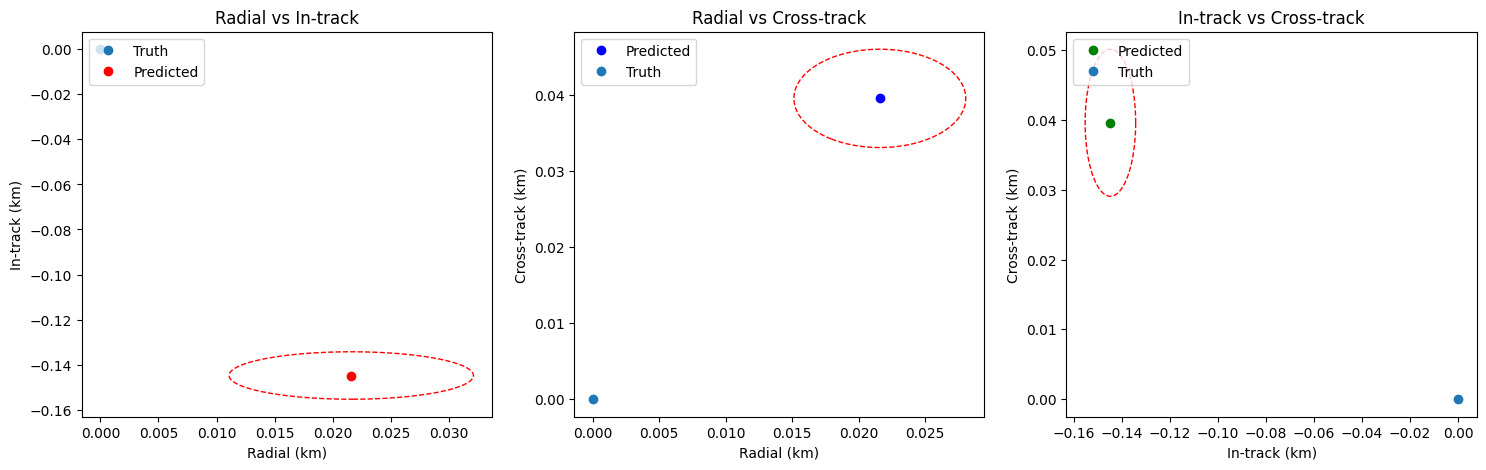

In [17]:
# savemat('smithT_poscov_case' + case + '.mat', {'smithT_pos_case' + case : y_final[0:3], 'smithT_poscov_case' + case : cov[0:3, 0:3]}, oned_as='column')
np.set_printoptions(precision=20, suppress=False)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

one_day_truth = np.array([-6330.16736001325, 3306.81591178162, 127.736863438565, -3.43787907681733, -6.63350511630163, -0.235613730204275])
seven_day_truth = np.array([445.825159257239,  -7100.15487544519, -183.846642900717, 7.48607847654087, 0.468696626655197, 0.177504090224814])

y_final, cov = loadmat('smithT_poscov_caseC.mat')['smithT_pos_caseC'], loadmat('smithT_poscov_caseC.mat')['smithT_poscov_caseC']
print(y_final.T[0])
y_final = y_final.T[0]
RIC_pred, RIC_cov = eci_to_ric(seven_day_truth[0:3], seven_day_truth[3:6], y_final, cov[0:3, 0:3])


# print('radial, intrack, crosstrack', RIC_pred)
# print('covariance', RIC_cov)

# error_ellipse_RI = error_ellipse(RIC_pred[0:2], RIC_cov[0:2, 0:2], n_sigma=3)
# error_ellipse_RC = error_ellipse(RIC_pred[[0, 2]], RIC_cov[[0, 2], [0, 2]], n_sigma=3)
# error_ellipse_IC = error_ellipse(RIC_pred[1:3], RIC_cov[1:3, 1:3], n_sigma=3)
# print('error ellipse', error_ellipse_RIC)

radial = RIC_pred[0]
in_track = RIC_pred[1]
cross_track = RIC_pred[2]


# ri_ellipse_x = RIC_pred[0] + error_ellipse_RIC[0] * np.cos(np.linspace(0, 2 * np.pi, 100))
# ri_ellipse_y = RIC_pred[1] + error_ellipse_RIC[1] * np.sin(np.linspace(0, 2 * np.pi, 100))

# rc_ellipse_x = RIC_pred[0] + error_ellipse_RIC[0] * np.cos(np.linspace(0, 2 * np.pi, 100))
# rc_ellipse_y = RIC_pred[2] + error_ellipse_RIC[2] * np.sin(np.linspace(0, 2 * np.pi, 100))

# ic_ellipse_x = RIC_pred[1] + error_ellipse_RIC[1] * np.cos(np.linspace(0, 2 * np.pi, 100))
# ic_ellipse_y = RIC_pred[2] + error_ellipse_RIC[2] * np.sin(np.linspace(0, 2 * np.pi, 100))
plot_ellipses(RIC_pred[0:2], RIC_cov[0:2, 0:2],3, ax[0])
plot_ellipses([RIC_pred[0], RIC_pred[2]], np.array([[RIC_cov[0, 0], RIC_cov[0, 2]],[RIC_cov[2, 0], RIC_cov[2, 2]]]),3, ax[1])
plot_ellipses(RIC_pred[1:3], RIC_cov[1:3, 1:3],3, ax[2])

ax[0].plot(0, 0, 'o', label='Truth')
# ax[0].plot(error_ellipse_RI[0], error_ellipse_RI[1], 'r', label='Error Ellipse')
ax[0].plot(radial, in_track, 'ro', label='Predicted')

ax[1].plot(radial, cross_track, 'bo', label='Predicted')
ax[1].plot(0, 0, 'o', label='Truth')
# ax[1].plot(error_ellipse_RC[0], error_ellipse_RC[1], 'r', label='Error Ellipse')

ax[2].plot(in_track, cross_track, 'go', label='Predicted')
ax[2].plot(0, 0, 'o', label='Truth')
# ax[2].plot(error_ellipse_IC[0], error_ellipse_IC[1], 'r', label='Error Ellipse')


ax[0].set_xlabel('Radial (km)')
ax[0].set_ylabel('In-track (km)')
ax[0].set_title('Radial vs In-track')
# ax[0].set_xlim(-0.05, 0.05)
# ax[0].set_ylim(-0.05, 0.05)
ax[0].legend(loc = 'upper left')

ax[1].set_xlabel('Radial (km)')
ax[1].set_ylabel('Cross-track (km)')
# ax[1].set_xlim(-0.05, 0.05)
# ax[1].set_ylim(-0.05, 0.05)
ax[1].set_title('Radial vs Cross-track')
ax[1].legend(loc = 'upper left')

ax[2].set_xlabel('In-track (km)')
ax[2].set_ylabel('Cross-track (km)')
ax[2].set_title('In-track vs Cross-track')
# ax[2].set_xlim(-0.05, 0.05)
# ax[2].set_ylim(-0.05, 0.05)
ax[2].legend(loc = 'upper left')




In [ ]:
print(np.linalg.cholesky(np.array([[8.69760324966389e-05,	1.50546443221012e-09,	-6.90939075374899e-11],
[1.50546443217131e-09,	8.69764243865732e-05,	3.01172475747682e-10],
[-6.90939076161431e-11,	3.01172475793887e-10,	8.69757274155812e-05]])))

In [13]:
np.set_printoptions(precision=6, suppress=True)
print('cov\n', cov[0:3, 0:3])
print('y_final', y_final)
print('one_day_truth', one_day_truth)
print('residuals', np.linalg.norm(one_day_truth- y_final))
print('choslesky', np.linalg.cholesky(cov[0:3, 0:3]))
print('RIC_pred', np.linalg.norm(RIC_pred))

cov
 [[ 0.000136 -0.000206 -0.000092]
 [-0.000206  0.000434  0.000154]
 [-0.000092  0.000154  0.000106]]
y_final [-6330.212942  3306.847322   127.771706    -3.437902    -6.633426
    -0.235566]
one_day_truth [-6330.16736   3306.815912   127.736863    -3.437879    -6.633505
    -0.235614]
residuals 0.06540935330160594
choslesky [[ 0.011651  0.        0.      ]
 [-0.017695  0.011014  0.      ]
 [-0.007923  0.001211  0.006453]]
RIC_pred 0.0654092840093707
